In [ ]:
import os, sys, random, warnings
from pathlib import Path
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

# Directory
dir = "/content/drive/MyDrive/Personal/Apziva/images"

# Setting random state for consistency
seed = 123
np.random.seed(seed)

# Confirm GPU


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wed Nov 12 03:00:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|          

In [ ]:
# Params
IMG_WIDTH  = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_NOT   = f"{dir}/training/notflip"
TRAIN_FLIP  = f"{dir}/training/flip"
TEST_NOT    = f"{dir}/testing/notflip"
TEST_FLIP   = f"{dir}/testing/flip"

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [ ]:
import os
print(os.path.exists(TRAIN_NOT))
print(os.path.exists(TRAIN_FLIP))
print(os.path.exists(TEST_NOT))
print(os.path.exists(TEST_FLIP))


True
True
True
True


In [6]:



def _list_images(p):
    p = Path(p)
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts:
        files += list(p.rglob(e))   # works whether images are directly inside or nested per-id
    return sorted(files)

def _load_and_resize(path):
    img = imread(str(path))[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode="constant", preserve_range=True, anti_aliasing=True)
    return img.astype(np.uint8)

def load_binary_split():
    # Collect file paths and labels
    train_paths = _list_images(TRAIN_NOT)
    train_labels = [0]*len(train_paths)
    fp = _list_images(TRAIN_FLIP)
    train_paths += fp
    train_labels += [1]*len(fp)

    test_paths  = _list_images(TEST_NOT)
    test_labels = [0]*len(test_paths)
    fp = _list_images(TEST_FLIP)
    test_paths += fp
    test_labels += [1]*len(fp)

    # Shuffle deterministically
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(train_paths))
    train_paths = [train_paths[i] for i in idx]
    train_labels = np.array([train_labels[i] for i in idx], dtype=np.int32)

    idx = rng.permutation(len(test_paths))
    test_paths = [test_paths[i] for i in idx]
    test_labels = np.array([test_labels[i] for i in idx], dtype=np.int32)

    # Load pixels
    print("Loading and resizing training images...")
    X_train = np.zeros((len(train_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i, p in tqdm(list(enumerate(train_paths)), total=len(train_paths)):
        X_train[i] = _load_and_resize(p)

    print("Loading and resizing test images...")
    X_test = np.zeros((len(test_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i, p in tqdm(list(enumerate(test_paths)), total=len(test_paths)):
        X_test[i] = _load_and_resize(p)

    # Scale to [0,1] floats for CNN input
    X_train = (X_train / 255.0).astype(np.float32)
    X_test  = (X_test  / 255.0).astype(np.float32)

    return X_train, train_labels, X_test, test_labels, train_paths, test_paths

X_train, y_train, X_test, y_test, train_files, test_files = load_binary_split()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Loading and resizing training images...


100%|██████████| 2392/2392 [23:17<00:00,  1.71it/s]


Loading and resizing test images...


100%|██████████| 597/597 [06:56<00:00,  1.43it/s]


(2392, 128, 128, 3) (2392,) (597, 128, 128, 3) (597,)


In [7]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2392, 128, 128, 3) (2392,) (597, 128, 128, 3) (597,)


In [8]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu"),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return m

model = build_cnn()
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.4933 - auc: 0.4762 - loss: 0.6957 - val_accuracy: 0.5142 - val_auc: 0.7203 - val_loss: 0.6916
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5110 - auc: 0.5401 - loss: 0.6914 - val_accuracy: 0.5243 - val_auc: 0.6046 - val_loss: 0.6872
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5430 - auc: 0.5778 - loss: 0.6850 - val_accuracy: 0.5293 - val_auc: 0.6078 - val_loss: 0.6807
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5666 - auc: 0.6099 - loss: 0.6746 - val_accuracy: 0.5243 - val_auc: 0.6244 - val_loss: 0.6685
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6200 - auc: 0.6638 - loss: 0.6471 - val_accuracy: 0.6449 - val_auc: 0.7305 - val_loss: 0.6308
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6392 - auc: 0.6872 - loss: 0.6348 - val_accuracy: 0.6935 - val_auc: 0.7465 - val_loss: 0.6148
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step 

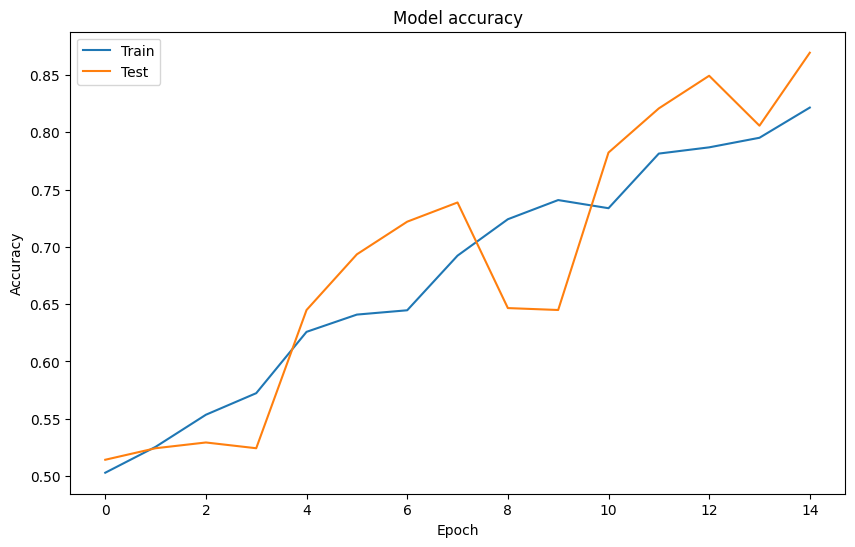

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


<Figure size 800x600 with 0 Axes>

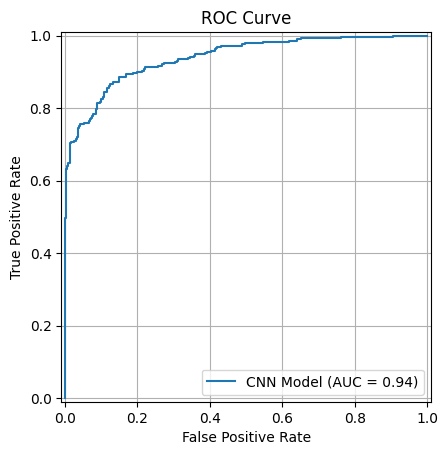

In [12]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, f1_score
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred_keras = model.predict(X_test).ravel()

# Calculate ROC curve and AUC
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

# Plot ROC curve
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_keras, tpr=tpr_keras, roc_auc=auc_keras, estimator_name='CNN Model').plot()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

In [13]:
# Calculate F1 Score
# First, convert probabilities to binary predictions (threshold at 0.5)
y_pred_binary = (y_pred_keras > 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8641


In [ ]:

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
model = Sequential([
    Input(shape = (img_dim, img_dim, 3)),
    Conv2D(8, (3,3), activation='relu', padding='same'),
    Conv2D(8, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(4, activation = 'softmax')
])
